# Kaiser SVD Analisys

In this example we factor a sparse matrix $\mathbf{M}$ of dimensions $patients \times drugs$ into 3 separate components of the form $\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$.

* $\mathbf{M}$ is the sparse matrix containg drugs purchased.
* $\mathbf{U}$ has rows of patients and columns of **right singular vectors**.
* $\mathbf{V}$ has rows of drugs and columns of **left singular vectors**.
* $\boldsymbol{\Sigma}$ is a rectangular diagonal matrix containing the **singular values** $\sigma_i$.

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import seaborn as sns
import os, re
import gpudb
import torch as th
import sys
from matplotlib import pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
import collections
#plotly.tools.set_credentials_file(username='rewreu', api_key='0rfHEVbuwMPJytN18N58')
    
os.environ["TFHUB_CACHE_DIR"]="/home/centos/centos/notebook"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Init Kinetica connection

In [2]:
_db = gpudb.GPUdb(encoding='BINARY', host="127.0.0.1", port="9191")

### Read input matrix from Kinetica

Input matrix is retrieved with the following SQL:

```sql
create or replace table KAISERS_SQL.PAT_GENDER_MATRIX as (
    select 
        rtf.PATIENT_ID,
        p.GENDER,
        d.THERAPEUTIC_IDENTIFIER as TID,
        max(UPPER(GENERIC_NAME)) as GENERIC_NAME,
        count(1) as RX_COUNT
    from RX_TX_FIN_EVENT as rtf
    join DRUG as d
        ON d.SRC_NHIN_STORE_ID = rtf.SRC_NHIN_STORE_ID
        AND rtf.DISPENSED_DRUG_NDC = d.NDC
    join PATIENT p
        on p.SRC_NHIN_STORE_ID = rtf.SRC_NHIN_STORE_ID
        and p.ID = rtf.PATIENT_ID
    where rtf.SRC_NHIN_STORE_ID = 900002841
    group by 1,2,3
);
```

In [3]:
def table_to_df(_db, _input_table):
    BATCH_SIZE=10000
    _offset = 0
    _table_df = pd.DataFrame()

    while True:
        _response = _db.get_records(table_name=_input_table,
                                    offset=_offset,
                                    limit=BATCH_SIZE)
        
        res_decoded = gpudb.GPUdbRecord.decode_binary_data(
            _response["type_schema"], 
            _response["records_binary"])
        
        _retrieved_records = len(res_decoded)
        _offset += _retrieved_records
        print('Got records: {}/{}'.format(_retrieved_records, _offset))
        
        _table_df = _table_df.append(res_decoded)
        
        if _response['has_more_records'] == False:
            break;
            
    print('Records Retrieved: {}'.format(_table_df.shape))
    _table_df.to_pickle(_input_table + '.pickle')
    return _table_df


In [4]:
_table_df = table_to_df(_db, 'PAT_GENDER_MATRIX')

## save to pickle for back up
#_table_df.to_pickle("c3df_cat.pickle")

Got records: 10000/10000
Got records: 10000/20000
Got records: 10000/30000
Got records: 10000/40000
Got records: 10000/50000
Got records: 10000/60000
Got records: 10000/70000
Got records: 10000/80000
Got records: 10000/90000
Got records: 10000/100000
Got records: 6457/106457
Records Retrieved: (106457, 5)


In [5]:
# quick recovery from break
if '_table_df' not in locals():
    _table_df = pd.read_pickle('PAT_GENDER_MATRIX.pickle')
    print('Recovered pickle results: {}'.format(_table_df.shape))

### Construct sparse matrix

In [6]:
_matrix_df = pd.crosstab(
    _table_df.PATIENT_ID, 
    _table_df.TID, 
    _table_df.RX_COUNT, 
    aggfunc=np.sum, 
#    normalize='index')
    normalize=False).fillna(0)

_matrix_df.head(10)
#_matrix_df.iloc[1,250:]

TID,1002,1013,104,105,106,108,11,1133,1139,1149,...,947,95,954,960,963,977,981,986,990,994
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Get SVD $\mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^*$ factors

In [7]:
# convert to numpy
_matrix_np = _matrix_df.as_matrix().astype(np.float64)

# Copy rating matrix from system RAM to GPU vRAM
_matrix_cuda = th.tensor(_matrix_np).cuda()

# Calculate SVD
_svd_u, _svd_s, _svd_v = th.svd(_matrix_cuda)

print(_svd_u.shape, _svd_s.shape, _svd_v.shape)

(torch.Size([19092, 493]), torch.Size([493]), torch.Size([493, 493]))


## Orthogonality

Dot product of any 2 columns is zero because the columns are orthogonal:

$\langle\mathbf{U_{j}},\mathbf{U_{k}}\rangle = 0$

Magnitude of any column is 1 because each column is a unit vector:

$\Vert \mathbf{U_{j}} \Vert^2$ = 1

In [8]:
u0 = _svd_u[:, 0]
u1 = _svd_u[:, 1]

dot = th.dot(u0,u0)
print('Dot product of u0,u0 is: {:f}'.format(dot.item()))

dot = th.dot(u0,u1)
print('Dot product of u0,u1 is: {:f}'.format(dot.item()))

Dot product of u0,u0 is: 1.000000
Dot product of u0,u1 is: -0.000000


### Plot singular values

The $\Sigma$ matrix contains the singular values that give the magnitudes of the singular vectors. We can calculate how much we lose through truncation.

Percent manitudes retained: 46.90%
Error : 53.10%


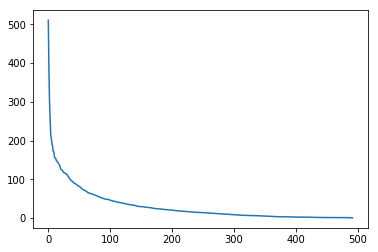

In [9]:
_svd_s_np = _svd_s.cpu().numpy()
plt.plot(np.arange(493), _svd_s_np)

TRUNCATE_COUNT = 50
_svd_s_sum = th.sum(_svd_s).item()
_svd_s_sum_approx = th.sum(_svd_s[:TRUNCATE_COUNT]).item()
_percent=_svd_s_sum_approx/_svd_s_sum
print('Percent manitudes retained: {:.2%}'.format(_percent))
_error=1-_percent
print('Error : {:.2%}'.format(_error))

### Truncate singular vectors

We can truncate trailing singular vectors to get a reduced rank approximation $\tilde{\mathbf{M}} = \mathbf{U} \tilde{\boldsymbol{\Sigma}} \mathbf{V}^*$ where $\tilde{\boldsymbol{\Sigma}}$ has truncated diagonal values and $\tilde{\mathbf{M}}$ is an approximation of the original sparse matrix.

In [10]:
# shape before truncate
print(_svd_u.shape, _svd_s.shape, _svd_v.shape)

TRUNCATE_VECTORS = 10
_dim = min(TRUNCATE_VECTORS, _svd_u.shape[1])
_svd_u_approx = _svd_u[: , :_dim]
_svd_s_approx = _svd_s[:_dim]
_svd_v_approx = _svd_v[: , :_dim]

# shape after truncate
print(_svd_u_approx.shape, _svd_s_approx.shape, _svd_v_approx.shape)

(torch.Size([19092, 493]), torch.Size([493]), torch.Size([493, 493]))
(torch.Size([19092, 10]), torch.Size([10]), torch.Size([493, 10]))


### Calculate reduced rank M

In [11]:
# Get diagonal
_svd_s_diag = th.diag(_svd_s_approx)

# Get transpose
_svd_v_t = _svd_v_approx.t()

# multiply s*v
_matrix_approx = _svd_u_approx.matmul(_svd_s_diag).matmul(_svd_v_t)

# copy result back from vRAM to RAM
_matrix_approx = _matrix_approx.cpu().numpy()

### Compare original with reduced rank

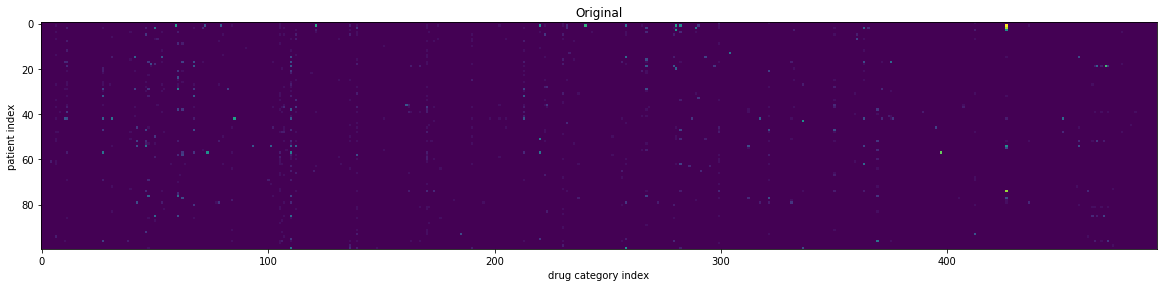

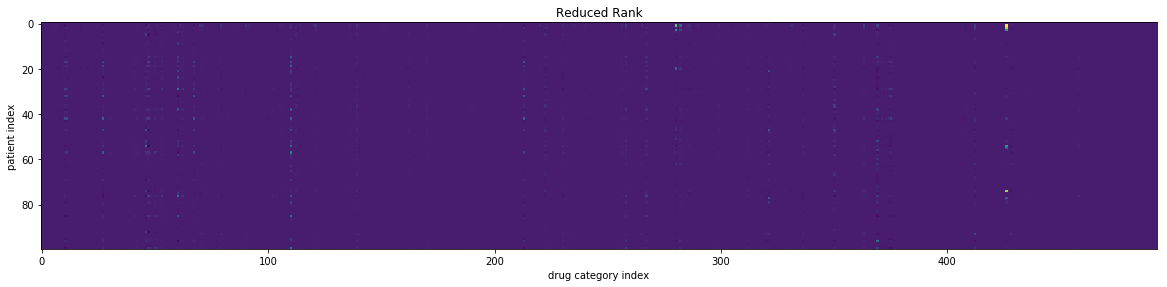

In [12]:
plt.figure(figsize=(20,150))
plt.imshow(_matrix_np[:100,:])
plt.xlabel('drug category index')
plt.ylabel('patient index')
plt.title('Original')
plt.show()

plt.figure(figsize=(20,150))
plt.imshow(_matrix_approx[:100,:1000])
plt.xlabel('drug category index')
plt.ylabel('patient index')
plt.title('Reduced Rank')
plt.show()

### Combine singular values

We can multiply the singular values from $ \boldsymbol{\Sigma}$ into $\mathbf{U}$ and $\mathbf{V}$. This gives matrices with magnitueds that can be used for clustering.

$
\mathbf{M} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^* 
= (\sqrt{\boldsymbol{\Sigma}} \mathbf{U}) ( \sqrt{\boldsymbol{\Sigma}} \mathbf{V}^* )
$

In [13]:
_svd_s_eigen = th.sqrt(_svd_s)
_svd_u_eigen = _svd_u.matmul(th.diag(_svd_s_eigen))
_svd_v_eigen = _svd_v.matmul(th.diag(_svd_s_eigen))

print(_svd_u.shape)
print(_svd_v.shape)

torch.Size([19092, 493])
torch.Size([493, 493])


### Save results to Kinetica

In [14]:
def save_results(df, res_table, schema='KAISERS_SQL'):
    _result_type = [[df.columns[0], gpudb.GPUdbRecordColumn._ColumnType.INT]]
    
    for _col_name in df.columns[1:]:
        _col_name = 'v{}'.format(_col_name)
        _result_type.append([_col_name, gpudb.GPUdbRecordColumn._ColumnType.DOUBLE])

    _db.clear_table(res_table, options={ 'no_error_if_not_exists':'true' })

    _result_table = gpudb.GPUdbTable(db=_db, _type=_result_type, name=res_table,
        options={'collection_name': schema,
                 'is_replicated': 'true'} )

    _insert_records = df.to_records(index=False)
    _insert_rows = map(list, _insert_records)
    print(type(_insert_rows))

    print('Inserting rows into <{}>: {}'.format(res_table, len(_insert_rows)))
    _result_table.insert_records(_insert_rows)


In [15]:
_patient_names = pd.DataFrame(_matrix_df.index)
_patient_sv = pd.DataFrame(_svd_u_eigen[:,:10].cpu().numpy())
_patient_vec = pd.concat([_patient_names, _patient_sv], axis=1)
save_results(_patient_vec, 'patient_sv')
_patient_vec.head(10)

<type 'list'>
Inserting rows into <patient_sv>: 19092


,PATIENT_ID,0,1,2,3,4,5,6,7,8,9
0,3,-0.026869,0.003544,-0.067632,0.007149,-0.019579,0.012598,0.039725,0.012359,-0.002720,0.005420
1,4,-1.025537,-0.915222,0.135088,0.506937,0.046075,0.790646,-0.736051,-0.174529,-0.203942,-0.047053
2,6,-0.835222,-0.685774,0.319621,-0.053120,-0.135096,-0.106425,0.025238,-0.039275,-0.001030,-0.026680
3,7,-0.465780,-0.495243,0.087060,0.222816,-0.009257,0.530207,-0.575800,-0.017807,-0.002585,0.176052
4,9,-0.065967,0.046649,-0.009301,0.070871,0.131696,0.014793,-0.015506,-0.036466,0.100262,-0.003387
5,10,-0.080683,0.061826,-0.024265,0.140817,-0.084936,-0.113579,-0.015990,0.257941,0.069405,-0.102313
6,11,-0.000987,0.000758,-0.000099,0.000010,0.001080,-0.000403,0.000270,-0.000125,-0.000270,-0.001447
7,12,-0.048768,0.030327,-0.014784,0.039065,-0.003877,0.008917,0.068761,0.014182,-0.050377,0.013645
8,13,-0.029016,0.037763,0.013422,-0.010194,-0.076811,0.006158,-0.001256,-0.055820,0.066318,-0.006859
9,15,-0.035533,0.035280,0.010889,0.016227,0.126579,-0.016414,0.009347,0.003277,0.135015,0.041639


In [16]:
_tid_names = pd.DataFrame(_matrix_df.columns)
_drug_sv = pd.DataFrame(_svd_v_eigen[:,:10].cpu().numpy())
_drug_vec = pd.concat([_tid_names,_drug_sv], axis=1)
save_results(_drug_vec, 'drug_sv')
_drug_vec.head(10)

<type 'list'>
Inserting rows into <drug_sv>: 493


,TID,0,1,2,3,4,5,6,7,8,9
0,1002,-0.000073,0.000065,-0.000042,0.000162,0.000097,-0.000235,0.000028,-0.000095,0.000270,-0.000164
1,1013,-0.000082,-0.000091,-0.000005,0.000045,-0.000072,0.000102,0.000255,0.000048,0.000003,-0.000002
2,104,-0.029558,0.019072,0.005004,-0.014532,-0.019556,-0.016535,-0.007420,0.022379,-0.007007,-0.029908
3,105,-0.027096,0.021333,-0.013344,0.024419,0.051139,0.025255,0.010653,-0.026288,-0.011587,-0.062321
4,106,-0.099617,0.031942,0.049758,-0.016589,0.071673,0.009588,-0.015417,0.048431,0.011317,0.003594
5,108,-0.029387,0.009056,-0.073421,-0.020252,0.031419,-0.037423,-0.033074,0.002370,-0.002154,0.005861
6,11,-0.862659,0.229033,-0.316997,0.526065,-0.179350,-0.414676,0.059366,-0.079363,0.296349,-0.295364
7,1133,-0.277131,-0.047655,-0.052281,0.199460,0.028029,0.266287,0.601075,-0.026674,0.000441,-0.046792
8,1139,-0.181559,0.070303,-0.128120,0.589495,-0.290053,-0.673455,-0.125343,0.131845,0.051035,0.013752
9,1149,-0.000025,0.000019,-0.000031,0.000167,-0.000066,-0.000082,0.000058,-0.000036,0.000021,-0.000106


### Create Matrixes for Male and Female

In [17]:
def gender_matrix(_df, _gender):
    # filter male
    _df_filtered = _df[_df.GENDER == _gender]

    # convert to sparse matrix
    _matrix_df = pd.crosstab(
        _df_filtered.PATIENT_ID, 
        _df_filtered.TID, 
        _df_filtered.RX_COUNT, 
        aggfunc=np.sum, 
        normalize=False).fillna(0)
    return _matrix_df

_matrix_pgm_m_df = gender_matrix(_table_df, 'M')
_matrix_pgm_m_np = _matrix_pgm_m_df.as_matrix().astype(np.float64)
print(_matrix_pgm_m_np.shape)

_matrix_pgm_f_df = gender_matrix(_table_df, 'F')
_matrix_pgm_f_np = _matrix_pgm_f_df.as_matrix().astype(np.float64)
print(_matrix_pgm_f_np.shape)

(8728, 399)
(10363, 442)


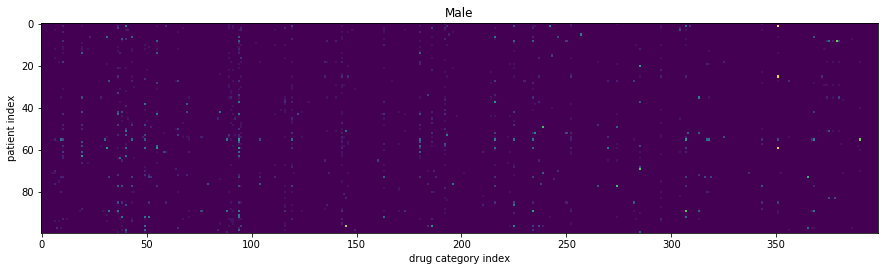

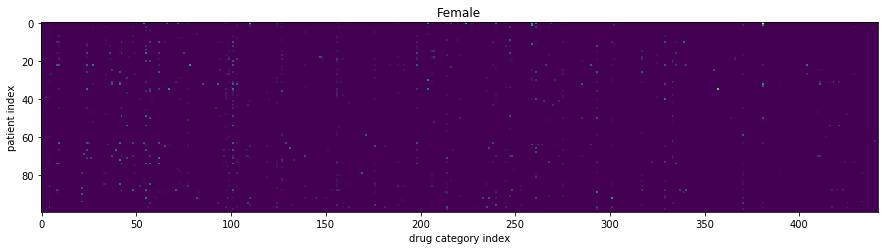

In [18]:
plt.figure(figsize=(15,150))
plt.xlabel('drug category index')
plt.ylabel('patient index')
plt.title('Male')
plt.imshow(_matrix_pgm_m_np[:100,:])
plt.show()

plt.figure(figsize=(15,150))
plt.xlabel('drug category index')
plt.ylabel('patient index')
plt.title('Female')
plt.imshow(_matrix_pgm_f_np[:100,:])
plt.show()

In [19]:

def save_svd_tables(_table_u, _table_v, _matrix_df, _matrix_np):
    # Copy rating matrix from system RAM to GPU vRAM
    _matrix_cuda = th.tensor(_matrix_np).cuda()

    # Calculate SVD
    _svd_u, _svd_s, _svd_v = th.svd(_matrix_cuda)
    print('SVD', _svd_u.shape, _svd_s.shape, _svd_v.shape)

    # multiply magnitudes
    _svd_s_eigen = th.sqrt(_svd_s)
    _svd_u_eigen = _svd_u.matmul(th.diag(_svd_s_eigen))
    _svd_v_eigen = _svd_v.matmul(th.diag(_svd_s_eigen))

    _patient_names = pd.DataFrame(_matrix_df.index)
    _patient_sv = pd.DataFrame(_svd_u_eigen[:,:10].cpu().numpy())
    _patient_vec = pd.concat([_patient_names, _patient_sv], axis=1)
    save_results(_patient_vec, _table_u)

    _tid_names = pd.DataFrame(_matrix_df.columns)
    _drug_sv = pd.DataFrame(_svd_v_eigen[:,:10].cpu().numpy())
    _drug_vec = pd.concat([_tid_names,_drug_sv], axis=1)
    save_results(_drug_vec, _table_v)
    

save_svd_tables('patient_sv_m', 'drug_sv_m', _matrix_pgm_m_df, _matrix_pgm_m_np)
save_svd_tables('patient_sv_f', 'drug_sv_f', _matrix_pgm_f_df, _matrix_pgm_f_np)

('SVD', torch.Size([8728, 399]), torch.Size([399]), torch.Size([399, 399]))
<type 'list'>
Inserting rows into <patient_sv_m>: 8728
<type 'list'>
Inserting rows into <drug_sv_m>: 399
('SVD', torch.Size([10363, 442]), torch.Size([442]), torch.Size([442, 442]))
<type 'list'>
Inserting rows into <patient_sv_f>: 10363
<type 'list'>
Inserting rows into <drug_sv_f>: 442
